## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import packages

In [3]:
#import some useful packeages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

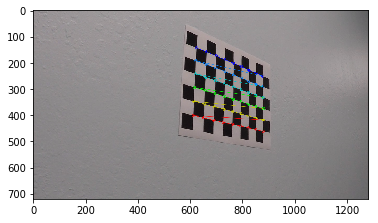

In [106]:
def Camera_Calibration (images, nx,ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # show the corners found on the distorted picture.
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            plt.imshow(img)
        if (len(objpoints) > 0):
       # calibrate the camera
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return ret, mtx, dist, rvecs, tvecs
        
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = Camera_Calibration(images,9,6)

## Distortion Correction

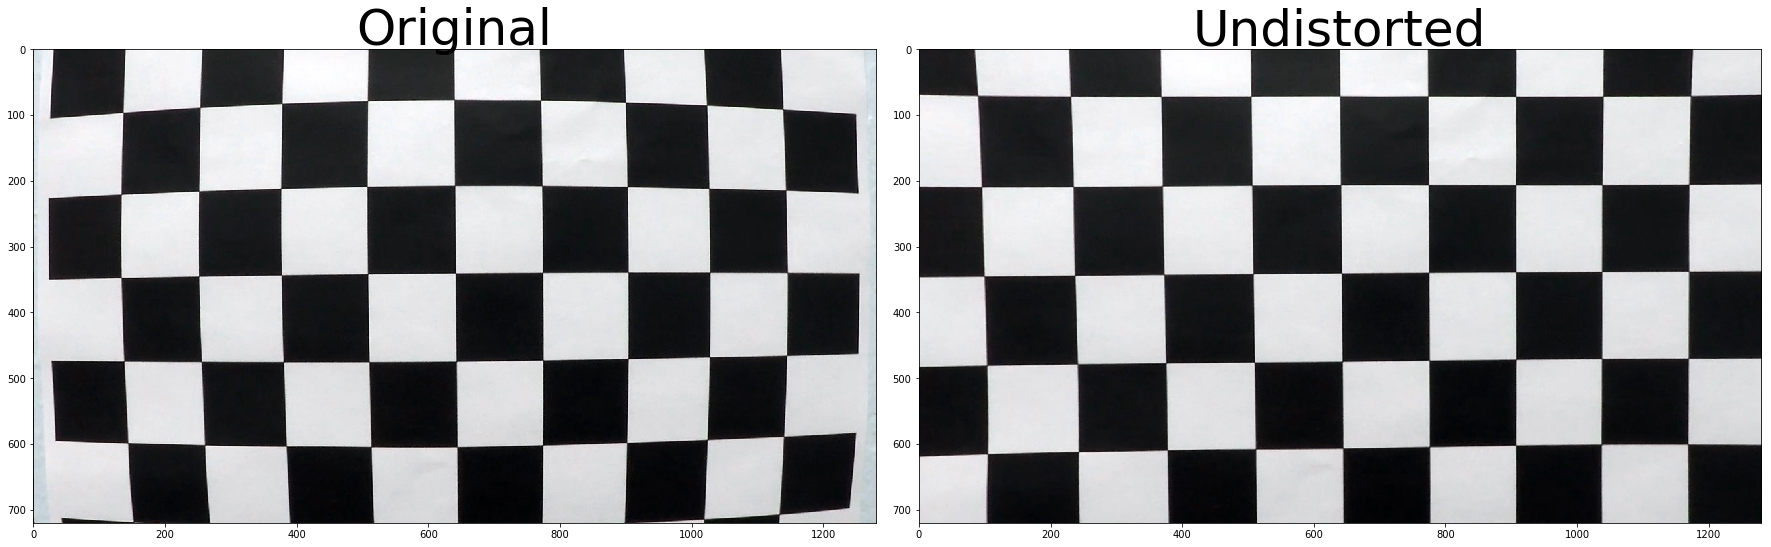

In [5]:
def Distortion_Correction(img,mtx,dist):
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

#try out with one of the test pictures and show the original and undistorted picture side by side. 
img = cv2.imread('./camera_cal/calibration1.jpg')
undistorted = Distortion_Correction(img,mtx,dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply Sobel Operator

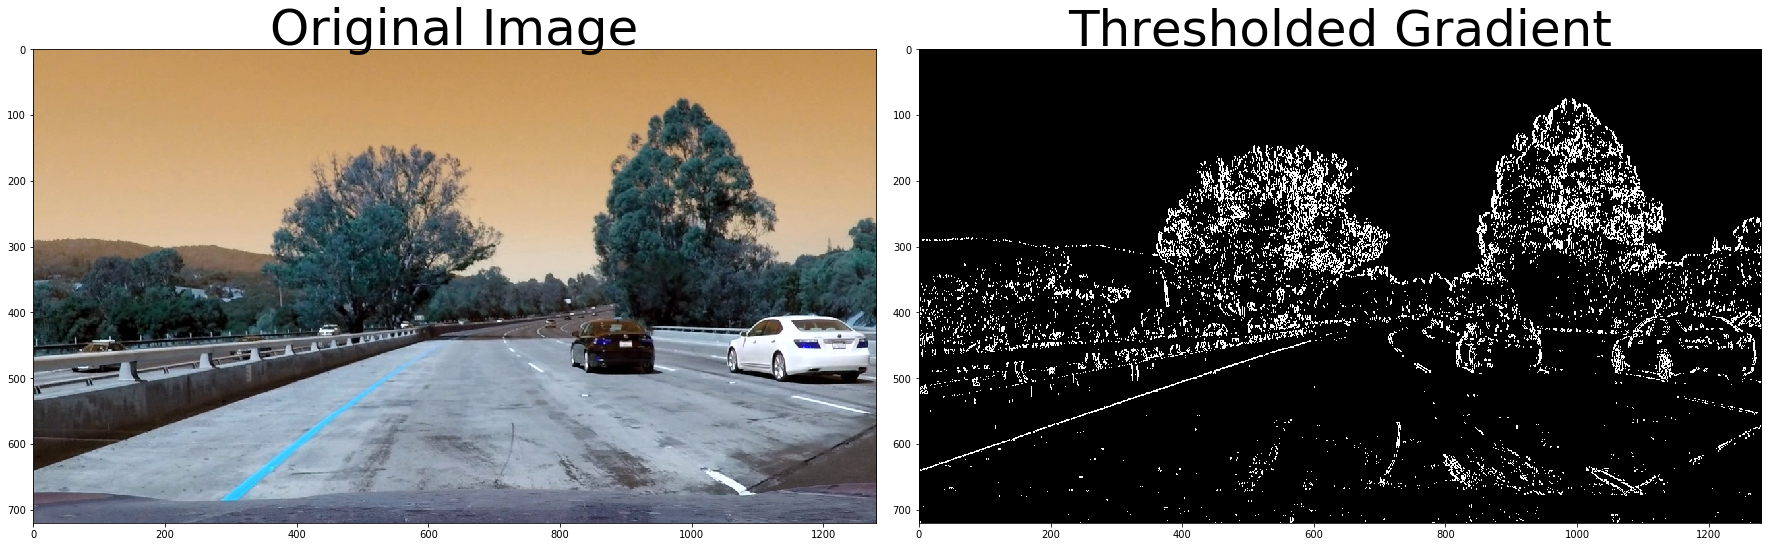

In [6]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output
    
#visualize the result
img = cv2.imread('./test_images/test1.jpg')
grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
# Plot 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Find Gradient Magnitude Threshold

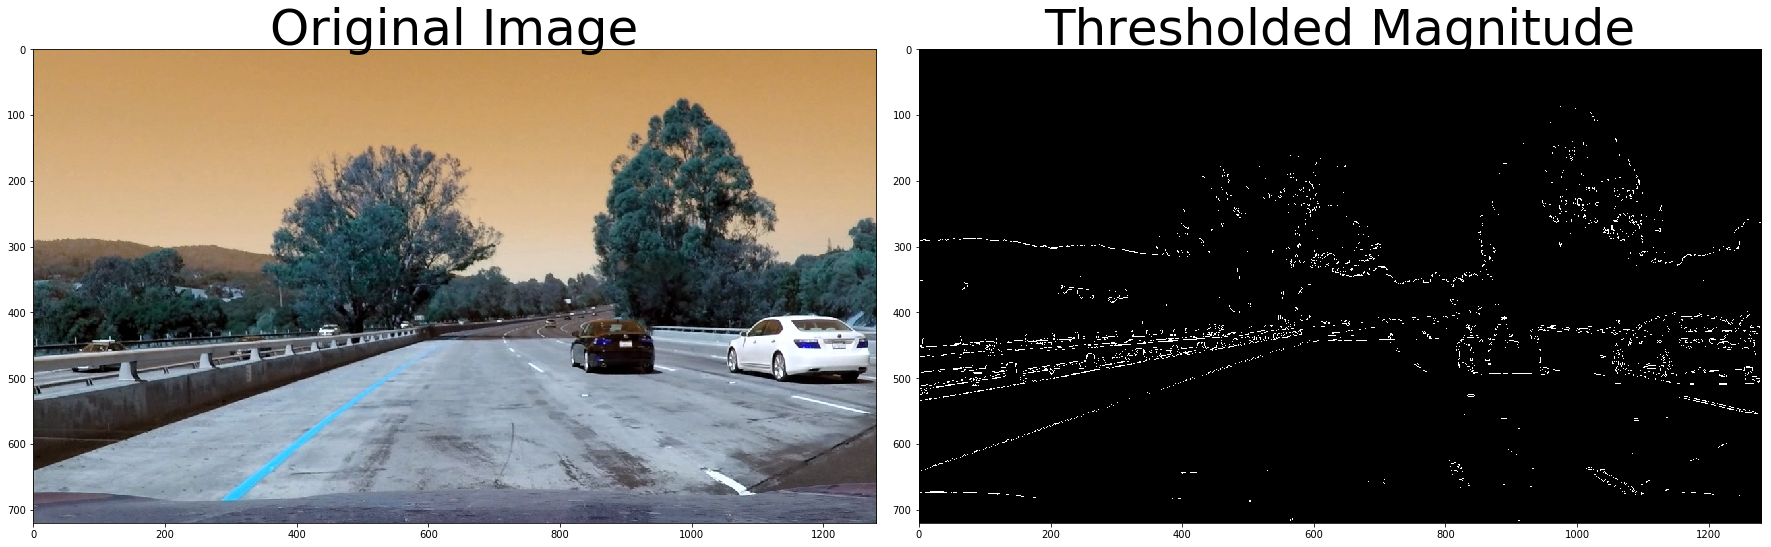

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

#visualize the result
img = cv2.imread('./test_images/test1.jpg')
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(70, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find Gradient Direction

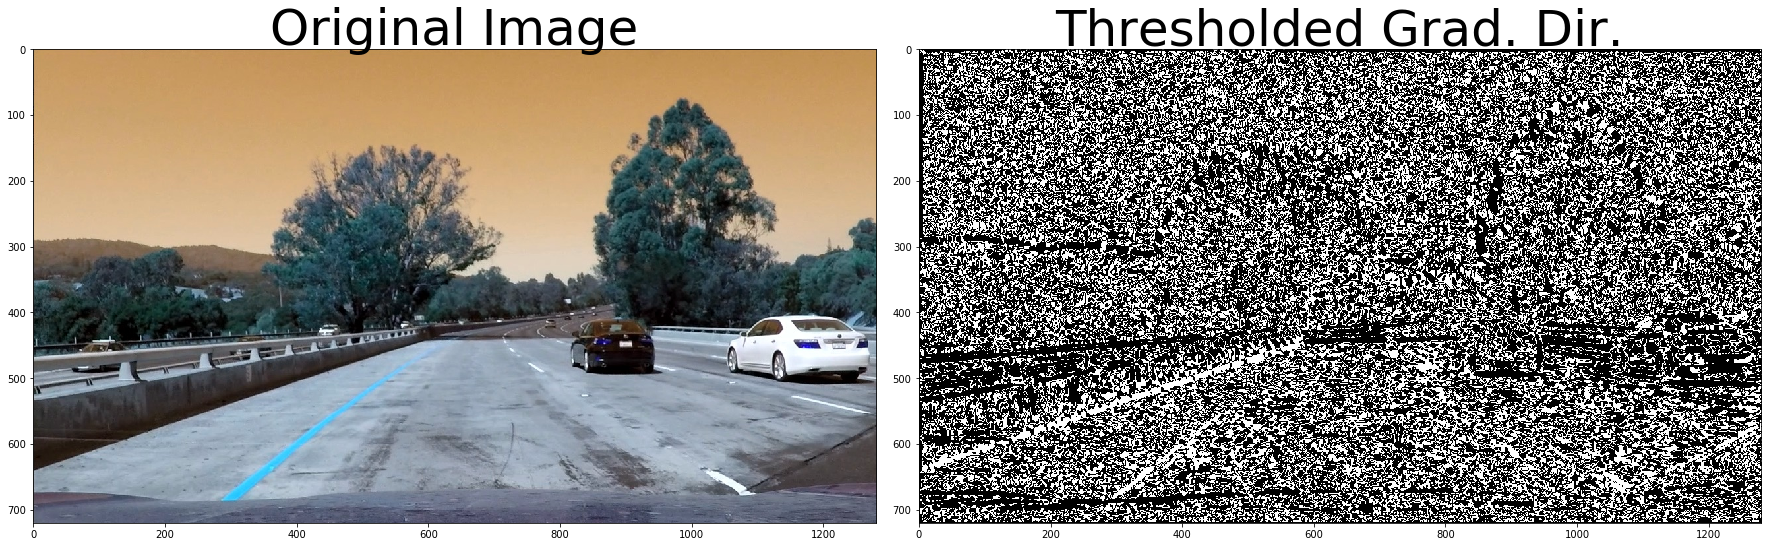

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#visualize the result
img = cv2.imread('./test_images/test1.jpg')
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color Thresholding (HLS)

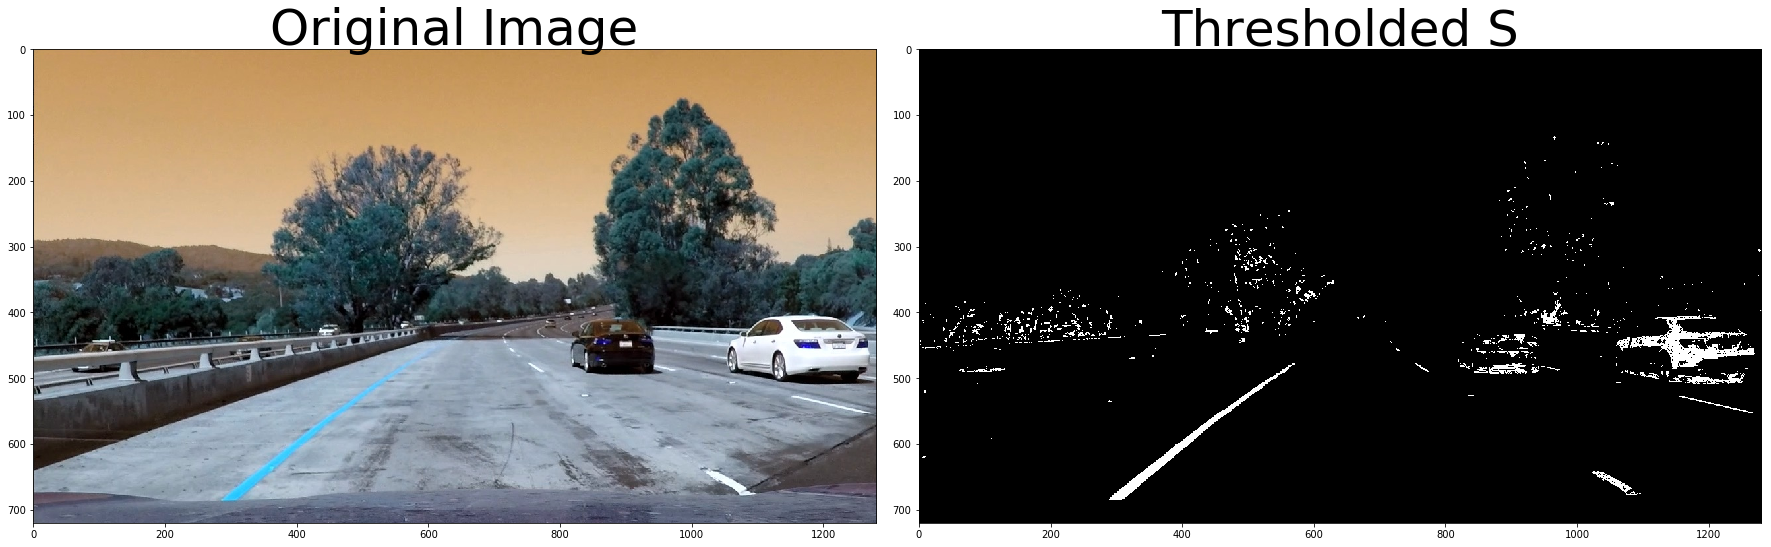

In [9]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

#visualize the result
img = cv2.imread('./test_images/test1.jpg')
hls_binary = hls_select(img, thresh=(180, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color and Gradient

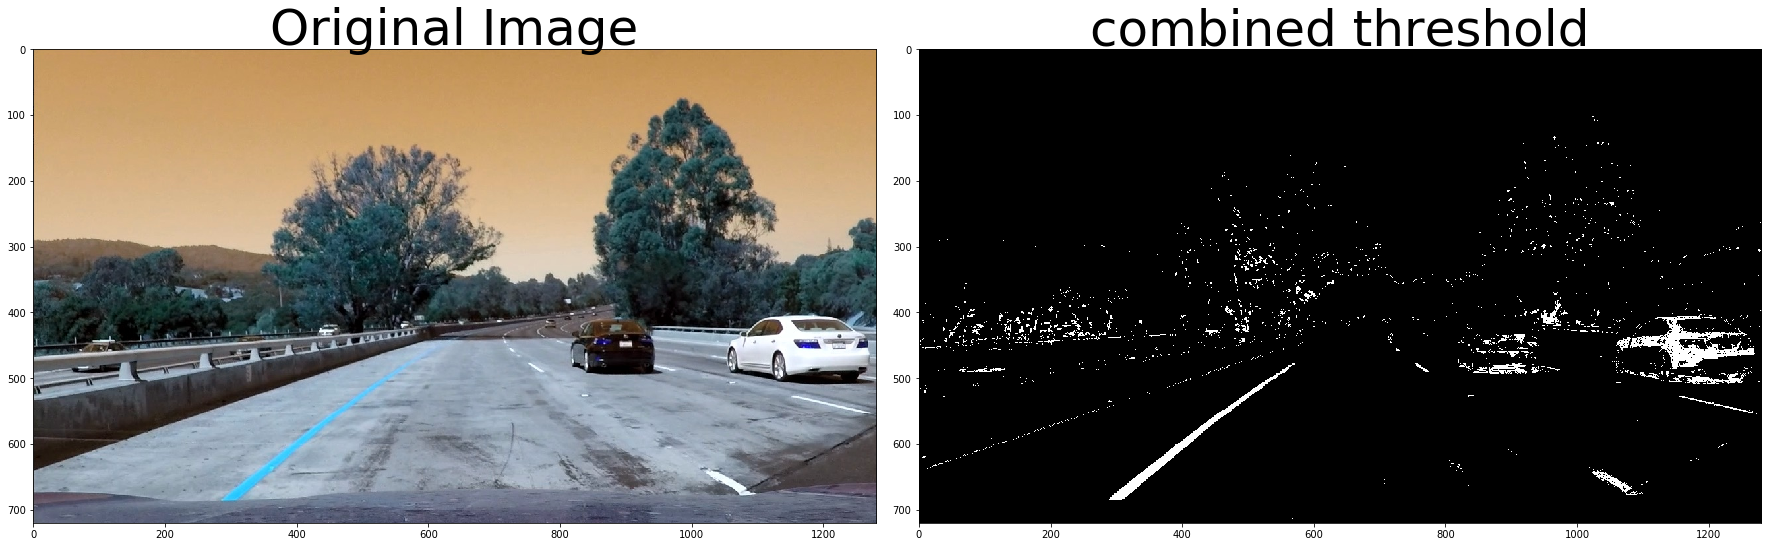

In [10]:
def Combine_four_thresh(grad_binary, mag_binary, dir_binary, hls_binary):
    CombinedThresh = np.zeros_like(dir_binary)
    CombinedThresh[(grad_binary == 1) & (mag_binary == 1) & (dir_binary == 1) | (hls_binary == 1)] = 1
    return CombinedThresh

#visualize the result
img = cv2.imread('./test_images/test1.jpg')
CombinedOutput = Combine_four_thresh(grad_binary, mag_binary, dir_binary, hls_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(CombinedOutput, cmap='gray')
ax2.set_title('combined threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Bird View Perspective Transform

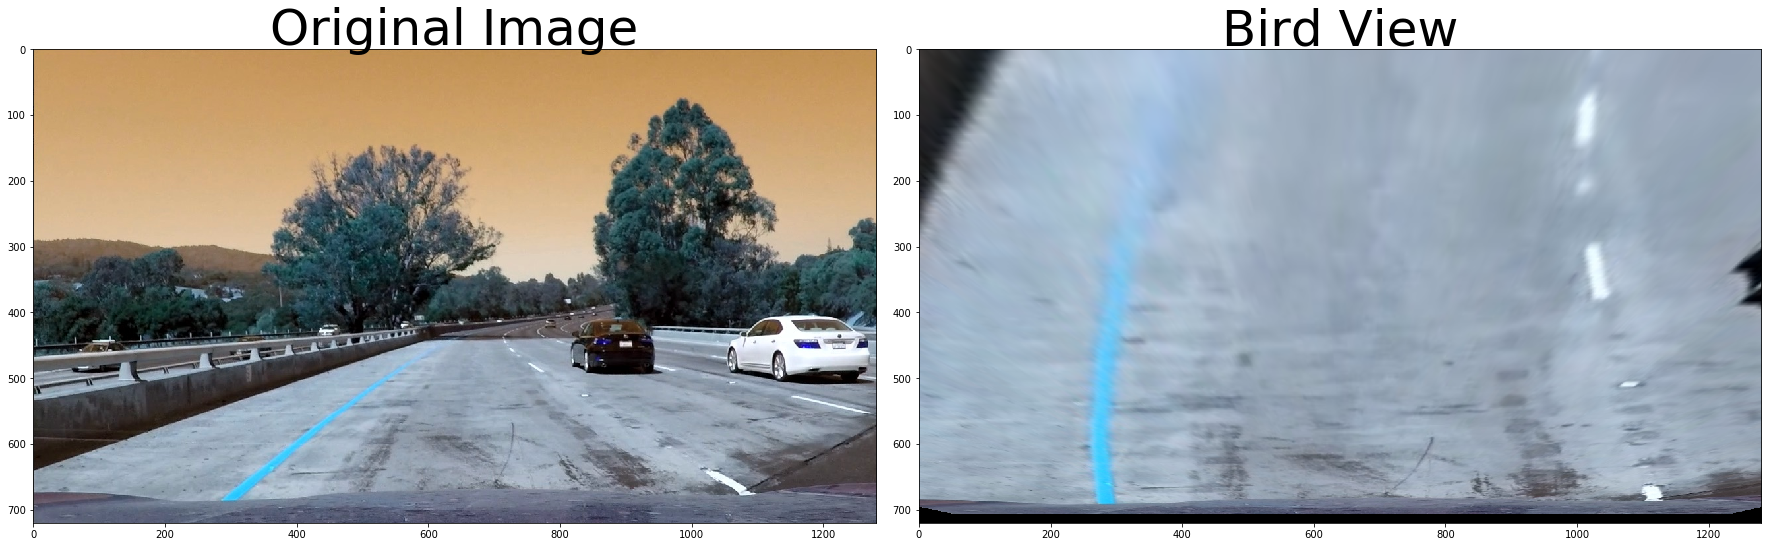

In [82]:
def Bird_View_Transform (img):
    img_size = (img.shape[1], img.shape[0])
    #offset = 100
    #from botom left to top left to top right to top bottom
    src = np.float32([[300,695], [600,450], [730,450], [1090,695]])
    dst = np.float32([[300, 695], [300, 0], [1090, 0], [1090, 695]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv
    
#visualize the result
img = cv2.imread('./test_images/test1.jpg')
warped, M, Minv  = Bird_View_Transform (img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Bird View', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find Lane Pixels

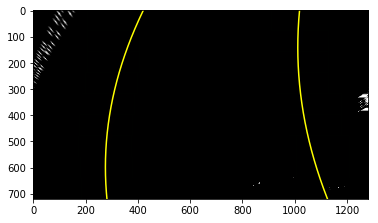

In [83]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

img = cv2.imread('./test_images/test1.jpg')
warped= Bird_View_Transform (CombinedOutput)[0]
out_img,left_fit, right_fit,left_fitx, right_fitx, ploty = fit_polynomial(warped)


plt.imshow(out_img)
 

## Find the lane boundary

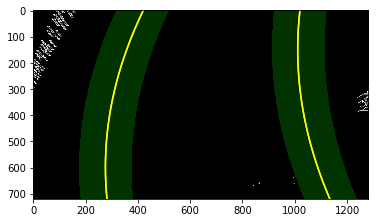

In [87]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit
def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, (left_fitx,ploty), (right_fitx, ploty),(left_fit,right_fit)

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,leftPixels,rightPixels,FitPoints = search_around_poly(warped, left_fit, right_fit)
result, (left_fitx,ploty), (right_fitx, ploty),(left_fit,right_fit) = search_around_poly(warped, left_fit, right_fit)
# View your output
plt.imshow(result)

## Determin Curvature

Left line curvature: 410.193472358 m
Right line curvature: 433.889152089 m


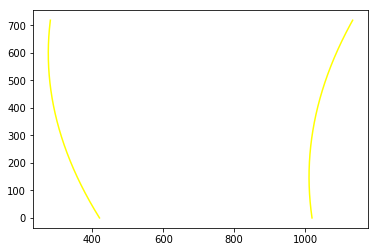

In [88]:
def measure_curvature_real(leftx, rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

#see the result
result,leftPixels,rightPixels,FitPoints = search_around_poly(warped,left_fit,right_fit)
curverads=measure_curvature_real(leftPixels[0],rightPixels[0])

print('Left line curvature:', curverads[0], 'm')
print('Right line curvature:', curverads[1], 'm')

## Drawing the lane

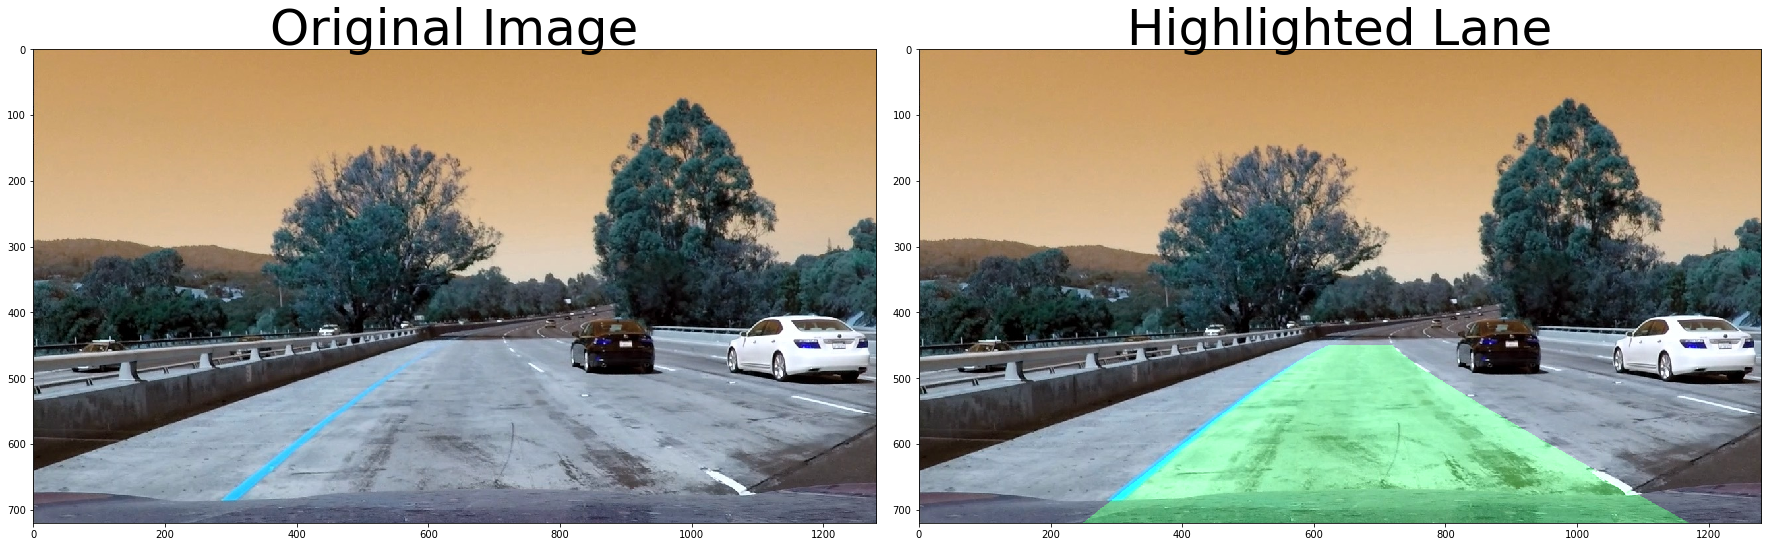

In [98]:
def Drawing_Lane (img, warped, leftPixels, rightPixels, Minv):
     #Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    left_fitx = leftPixels[0]
    right_fitx = rightPixels[0]
    ploty = leftPixels[1]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result
    
#Visualize the result
LaneHighlighted = Drawing_Lane(img, CombinedOutput, leftPixels, rightPixels, Minv)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(LaneHighlighted, cmap='gray')
ax2.set_title('Highlighted Lane', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Vehicle Position

In [99]:
def Vehicle_Position (leftx, rightx):
    imgx_center = img.shape[1]//2
    #vehicle Position in the detected lane
    vehicle_position = (leftx[-1]+rightx[-1])/2;
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    OffSet = ( imgx_center-vehicle_position)*xm_per_pix
    
    return OffSet
        
#Testing
OffSet = Vehicle_Position (leftPixels[0], rightPixels[0])
print ('Offset is:', OffSet, 'm.')

Offset is: -0.359446271367 m.


## Output curvature and vehicle offset

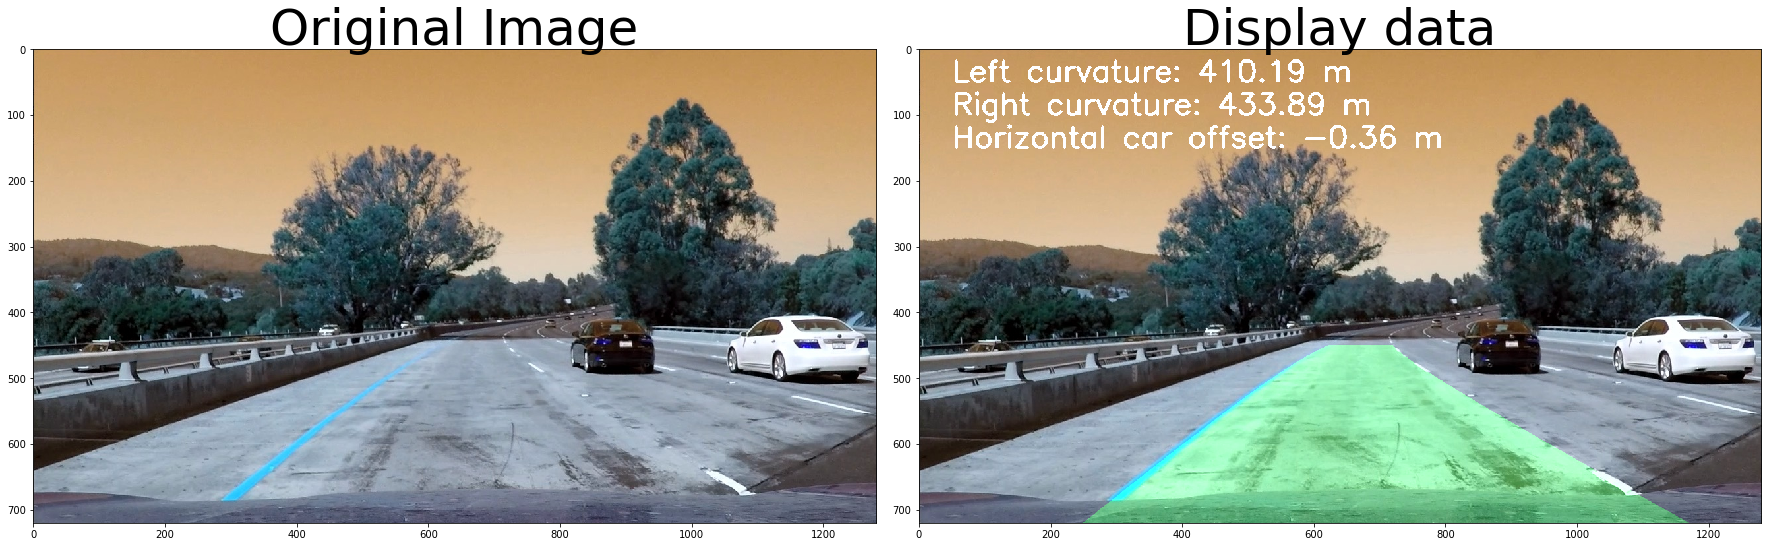

In [105]:
def Output_Numbers(img, leftx, rightx):
    curves = measure_curvature_real(leftx,rightx)
    offset =  Vehicle_Position (leftx, rightx)
    
    #display curvature and the vehicle position relative to lane center
    display_data = img.copy()
    cv2.putText(display_data, 'Left curvature: {:.2f} m'.format(curves[0]), 
                (50, 50), cv2.FONT_ITALIC , 1.5, (255,255,255), 3)
    cv2.putText(display_data, 'Right curvature: {:.2f} m'.format(curves[1]), 
                (50, 100), cv2.FONT_ITALIC , 1.5, (255,255,255), 3)
    cv2.putText(display_data, 'Horizontal car offset: {:.2f} m'.format(offset), 
                (50, 150), cv2.FONT_ITALIC , 1.5, (255,255,255), 3)
    
    return display_data

#testing
display_data=Output_Numbers(LaneHighlighted, leftPixels[0],rightPixels[0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(display_data, cmap='gray')
ax2.set_title('Display data', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline for Video Processing

In [112]:
class Line ():
    def __init__(self,imgs):
        imgs = glob.glob(imgs)
        #camera calibration
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = Camera_Calibration(imgs,9,6)
        self.lines_fit =None
        
    def __call__(self,img):
        #Distortion Correction
        undistorted = Distortion_Correction(img,mtx,dist)
        
        #Apply Sobel Operator
        grad_binary = abs_sobel_thresh(undistorted, orient='x', thresh_min=20, thresh_max=100)
        
        #find gradient magnitude threshold
        mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(70, 100))
        
        #find gradient direction
        dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
        
        #color thresholding (HlS)
        hls_binary = hls_select(undistorted, thresh=(180, 255))
        
        #combine 4 color and gradient threholds
        CombinedOutput = Combine_four_thresh(grad_binary, mag_binary, dir_binary, hls_binary)
        
        #Bird View Perspective Transform
        warped, M, Minv  = Bird_View_Transform (CombinedOutput)
        
        #Find the lane boundary
        result,leftPixels,rightPixels,self.FitPoints = search_around_poly(warped, self.left_fit, self.right_fit)
        
        #highligh the detected lanes
        LaneHighlighted = Drawing_Lane(img, warped, leftPixels, rightPixels, Minv)
        
        #show curves and vehicle positions relative to lane center
        display_data=Output_Numbers(LaneHighlighted, leftPixels[0],rightPixels[0])
        
        return display_data
        

In [113]:
input_video = './project_video.mp4'
output_video = './project_video_processed.mp4'

clip1 = VideoFileClip(input_video)
processedVideo = line ('./camera_cal/calibration*.jpg')
white_clip = clip1.fl_image(processedVideo)

%time white_clip.write_videofile(output_video, audio=False)

NameError: name 'VideoFileClip' is not defined